# Text Analysis for Mental health 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
stemmer = nltk.SnowballStemmer("english")
import seaborn as sns
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import warnings
from wordcloud import WordCloud

In [2]:
train = pd.read_csv("dreaddit-train.csv")
test = pd.read_csv("dreaddit-test.csv")

In [3]:
full = train.append(test)
full.shape
full.head()

/var/folders/1k/1dyc6nt54vlfh7v77pk872vc0000gn/T/ipykernel_86626/1991155964.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full = train.append(test)


,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1.521614e+09,5,1.806818,...,1.000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1.527010e+09,4,9.429737,...,1.125,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.8,1.535936e+09,2,7.769821,...,1.000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,1,0.6,1.516430e+09,0,2.667798,...,1.000,1.1250,1.0,1.75356,1.52114,1.98848,0.50,5,4.104027,0.141671
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,1,0.8,1.539809e+09,24,7.554238,...,1.000,1.1250,1.0,1.77644,1.64872,1.81456,1.00,1,7.910952,-0.204167


In [4]:
print("Rows :", full.shape[0])
print("Columns :", full.shape[1])
print()
print("Categorical columns :")
print(full.select_dtypes(include=['object']).apply(pd.Series.nunique, axis=0))
print()
print("Description :")
print(full.info())
print()
print("Nulls:")
print(full.isnull().sum())

Rows : 3553
Columns : 116

Categorical columns :
subreddit           10
post_id           2929
sentence_range     194
text              3532
dtype: int64

Description :
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3553 entries, 0 to 714
Columns: 116 entries, subreddit to sentiment
dtypes: float64(107), int64(5), object(4)
memory usage: 3.2+ MB
None

Nulls:
subreddit                   0
post_id                     0
sentence_range              0
text                        0
id                          0
                           ..
lex_dal_avg_pleasantness    0
social_upvote_ratio         0
social_num_comments         0
syntax_fk_grade             0
sentiment                   0
Length: 116, dtype: int64


In [5]:
full.sample()

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
352,survivorsofabuse,6bn4xx,"(30, 35)",Is this common? How did you deal with it? I wa...,15663,1,1.0,1.495004e+09,5,0.084239,...,1.1111,1.1429,1.0,1.73719,1.36364,1.87092,1.0,7,2.480996,-0.068452


## Correlation Heatmap

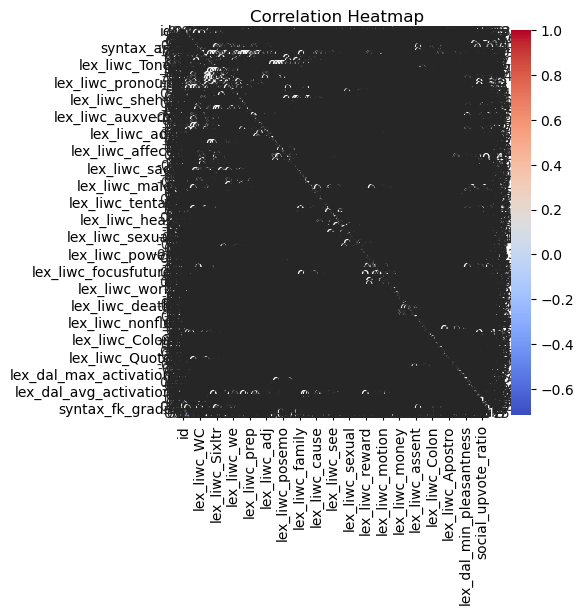

In [6]:
# Assuming you have additional numerical features in your DataFrame
correlation_matrix = full.corr()

plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title('Correlation Heatmap')
plt.show()

# Data Summary 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3553 entries, 0 to 714
Columns: 116 entries, subreddit to sentiment
dtypes: float64(107), int64(5), object(4)
memory usage: 3.2+ MB
None


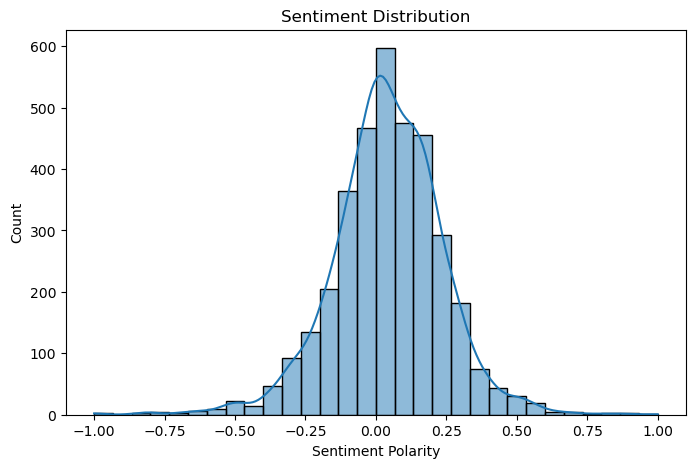

In [7]:
# Data Summary
print(full.info())

# Sentiment Distribution
plt.figure(figsize=(8, 5))
sns.histplot(full['sentiment'], bins=30, kde=True)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Polarity')
plt.show()

# # Meaning Category Distribution
# plt.figure(figsize=(6, 4))
# sns.countplot(data=full, x='text', palette=["#e1c0b6", "#a3b8c8"])
# plt.title('Meaning Category Distribution')
# plt.show()


## Sentiment Analysis

In [8]:
import pandas as pd
from textblob import TextBlob

# Define a function to calculate sentiment polarity
def calculate_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Create a new DataFrame with the 'text' column
posts = pd.DataFrame(full["text"], columns=["text"])

# Add a 'sentiment' column with sentiment polarity values
posts["sentiment"] = posts["text"].apply(calculate_sentiment)

# Display the first few rows of the DataFrame
print(posts.head())


                                                text  sentiment
0  He said he had not felt that way before, sugge...  -0.002742
1  Hey there r/assistance, Not sure if this is th...   0.292857
2  My mom then hit me with the newspaper and it s...   0.011894
3  until i met my new boyfriend, he is amazing, h...   0.141671
4  October is Domestic Violence Awareness Month a...  -0.204167


In [9]:
import pandas as pd


value_exploration = posts["sentiment"].agg(["min", "max"])
print("Value Exploration:")
print("Minimum Sentiment:", value_exploration["min"])
print("Maximum Sentiment:", value_exploration["max"])
print()

# Sentiment Counts
sentiment_counts = posts["sentiment"].value_counts()
print("Counts:")
print(sentiment_counts)


Value Exploration:
Minimum Sentiment: -1.0
Maximum Sentiment: 1.0

Counts:
 0.000000    84
 0.250000    24
 0.100000    23
 0.150000    17
 0.125000    16
             ..
 0.200926     1
-0.009375     1
-0.045833     1
 0.244643     1
 0.136364     1
Name: sentiment, Length: 2627, dtype: int64


## Text Preprocessing

In [10]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

# Download the stopwords dataset if not already downloaded
nltk.download("stopwords")

# Initialize the Porter Stemmer
stemmer = PorterStemmer()


stopwords_set = set(stopwords.words("english"))


def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove digits and non-word characters
    text = re.sub(r'\w*\d\w*', '', text)
    
    # Tokenize and remove stopwords
    words = text.split()
    filtered_words = [word for word in words if word not in stopwords_set]
    
    # Stem the words
    stemmed_words = [stemmer.stem(word) for word in filtered_words]
    
    # Join the words back into a string
    processed_text = ' '.join(stemmed_words)
    
    return processed_text

# Apply the text preprocessing function to the 'text' column
posts["text"] = posts["text"].apply(preprocess_text)

# Display the preprocessed text
print(posts["text"])


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sowmyaburuju/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0      said felt way before, sugget go rest ..trigger...
1      hey r/assistance, sure right place post this.....
2      mom hit newspap shock would this, know like pl...
3      met new boyfriend, amazing, kind, sweet, good ...
4      octob domest violenc awar month domest violenc...
                             ...                        
710    horribl vivid nightmar everi night. sometim th...
711    also can't think without get angri jealou agai...
712    furthermore, told got realli seriou anxieti de...
713    here' link amazon wish list two item are: link...
714    keep us protected? alreadi told unwelcom perso...
Name: text, Length: 3553, dtype: object


## Word Clouds

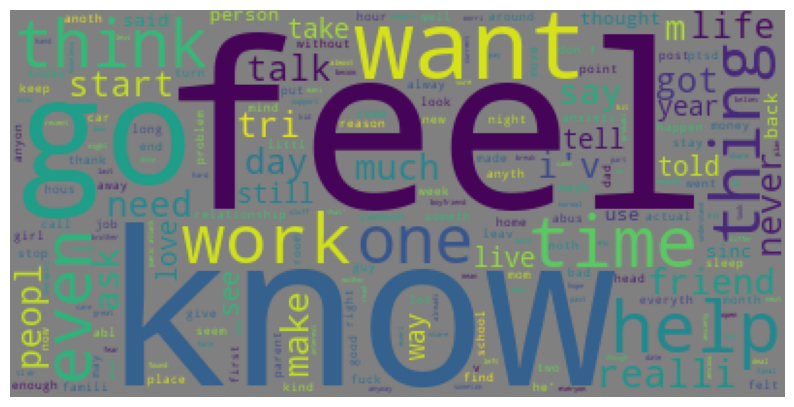

In [11]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def generate_wordcloud(data, bgcolor):
    plt.figure(figsize=(10, 10))
    
    # Create a WordCloud object with the specified background color and stopwords
    wc = WordCloud(background_color=bgcolor, stopwords=STOPWORDS)
    
    # Generate the word cloud from the input data
    wc.generate(' '.join(data))
    
    # Display the word cloud
    plt.imshow(wc)
    plt.axis("off")
    plt.show()

generate_wordcloud(posts["text"], 'grey')


In [12]:
# Define a mapping of labels to meanings
label_meaning_mapping = {0: "Unstressed", 1: "Stressed"}

# Add a 'meaning' column to the 'full' DataFrame
full["meaning"] = full["label"].map(label_meaning_mapping)

# Create a new DataFrame containing only the 'text' and 'meaning' columns
posts = full[["text", "meaning"]]

# Display the first few rows of the DataFrame
print(posts.head())


                                                text     meaning
0  He said he had not felt that way before, sugge...    Stressed
1  Hey there r/assistance, Not sure if this is th...  Unstressed
2  My mom then hit me with the newspaper and it s...    Stressed
3  until i met my new boyfriend, he is amazing, h...    Stressed
4  October is Domestic Violence Awareness Month a...    Stressed


In [13]:
# Apply sentiment analysis to the 'text' column and create a 'sentiment' column
posts["sentiment"] = posts["text"].apply(lambda text: TextBlob(text).sentiment.polarity)

# Display the first few rows of the DataFrame
print(posts.head())


                                                text     meaning  sentiment
0  He said he had not felt that way before, sugge...    Stressed  -0.002742
1  Hey there r/assistance, Not sure if this is th...  Unstressed   0.292857
2  My mom then hit me with the newspaper and it s...    Stressed   0.011894
3  until i met my new boyfriend, he is amazing, h...    Stressed   0.141671
4  October is Domestic Violence Awareness Month a...    Stressed  -0.204167


/var/folders/1k/1dyc6nt54vlfh7v77pk872vc0000gn/T/ipykernel_86626/3809718347.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts["sentiment"] = posts["text"].apply(lambda text: TextBlob(text).sentiment.polarity)


I       13232
to      10249
and      9579
the      7205
a        6461
my       4966
of       4479
in       3393
that     3345
for      2996
me       2926
was      2793
is       2601
have     2547
it       2509
with     2472
but      2274
this     1906
on       1756
he       1734
Name: text, dtype: int64


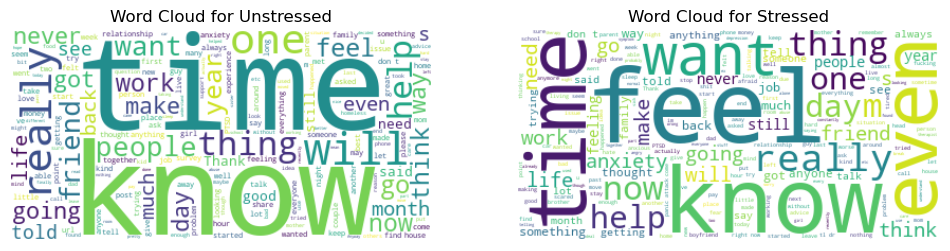

In [14]:
from wordcloud import WordCloud

# Word Frequency Analysis
# Assuming 'processed_text' is a preprocessed version of the 'text' column
word_frequencies = full['text'].str.split().explode().value_counts()

# Display the top N most common words
N = 20
print(word_frequencies.head(N))

# Word Clouds for 'Unstressed' and 'Stressed
wc_unstressed = WordCloud(background_color='white').generate(' '.join(full[full['meaning'] == 'Unstressed']['text']))
wc_stressed = WordCloud(background_color='white').generate(' '.join(full[full['meaning'] == 'Stressed']['text']))

# Display the word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wc_unstressed, interpolation='bilinear')
plt.title('Word Cloud for Unstressed')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wc_stressed, interpolation='bilinear')
plt.title('Word Cloud for Stressed')
plt.axis('off')

plt.show()


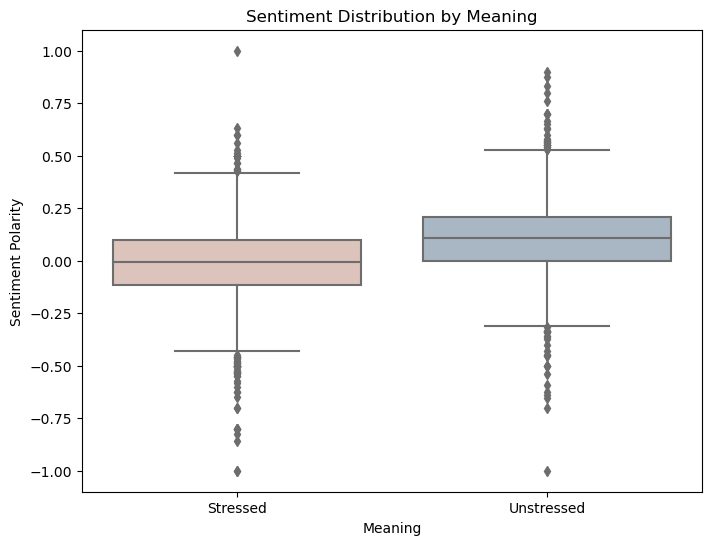

In [15]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=full, x='meaning', y='sentiment', palette=["#e1c0b6", "#a3b8c8"])
plt.title('Sentiment Distribution by Meaning')
plt.xlabel('Meaning')
plt.ylabel('Sentiment Polarity')
plt.show()


In [16]:
def naive_depression_analysis(text):
    # List of depressive keywords or phrases
    depressive_keywords =  [
    'sad', 'unhappy', 'melancholy', 'despair', 'hopeless', 'helpless',
    'worthless', 'lonely', 'isolated', 'gloomy', 'miserable', 'dejected',
    'despondent', 'desolate', 'downcast', 'disheartened', 'discouraged',
    'dismal', 'forlorn', 'blue', 'downhearted', 'woeful', 'downtrodden',
    'defeated', 'broken', 'anguished', 'mournful', 'troubled', 'painful',
    'sorrowful', 'heartbroken', 'heavyhearted', 'tearful', 'grief-stricken',
    'depressed', 'low', 'down', 'in the dumps', 'down in the dumps', 'down and out',
    'in despair', 'in the depths of despair', 'down in the mouth', 'woe', 'woefulness',
    'grief', 'sorrow', 'heartache', 'heartbreak', 'misery', 'desolation', 'despairing',
    'unfortunate', 'unlucky', 'unfortunate', 'bleak', 'dim', 'black', 'dark', 'grief',
    'forlornness', 'pessimistic', 'defeatism', 'apathy', 'disinterest', 'numbness',
    'emptiness', 'fatigue', 'exhaustion', 'sleeplessness', 'insomnia', 'anxiety',
    'nervousness', 'restlessness', 'irritability', 'worthlessness', 'self-loathing',
    'guilt', 'shame', 'regret', 'suicidal', 'suicide', 'broken-hearted', 'unloved',
    'unwanted', 'rejected', 'abandoned', 'failure', 'disappointment', 'loneliness',
    'isolation', 'withdrawal', 'alienation', 'indifference', 'loss', 'self-harm',
    'self-destructive', 'apathetic', 'numb', 'desperation', 'agony', 'anguish', 'frustration',
    'desperate', 'destitution', 'abysmal', 'down-and-out', 'forlorn-hope', 'oppressed',
    'bitter', 'bitterness', 'hostile', 'hostility', 'dissatisfied', 'dissatisfaction',
    'mourn', 'mourning', 'oppression', 'oppressive', 'tragic', 'tragedy', 'broke', 'desiring'
]


    # Count the occurrences of depressive keywords
    depressive_count = sum([1 for keyword in depressive_keywords if keyword in text.lower()])

    # Classify depression based on the count
    if depressive_count > 2:  # Adjust the threshold based on your dataset and observations
        return 1  # Depressive
    else:
        return 0  # Not depressive


text = "I feel really sad and lonely today. Everything seems hopeless."
result = naive_depression_analysis(text)
print(f'Depression analysis result: {result}')

Depression analysis result: 1


In [17]:
def weighted_depression_analysis(text):
    # Dictionary of depressive keywords and their weights
    depressive_keywords = {
        'sad': 1, 'unhappy': 1, 'melancholy': 1, 'despair': 2, 'hopeless': 2, 'helpless': 1,
        'worthless': 2, 'lonely': 1, 'isolated': 1, 'gloomy': 1, 'miserable': 2, 'dejected': 1,
        'despondent': 2, 'desolate': 2, 'downcast': 1, 'disheartened': 1, 'discouraged': 1,
        'dismal': 1, 'forlorn': 1, 'blue': 1, 'downhearted': 1, 'woeful': 1, 'downtrodden': 1,
        'defeated': 2, 'broken': 2, 'anguished': 2, 'mournful': 2, 'troubled': 1, 'painful': 1,
        'sorrowful': 2, 'heartbroken': 2, 'heavyhearted': 1, 'tearful': 1, 'grief-stricken': 2,
        'depressed': 2, 'low': 1, 'down': 1, 'in the dumps': 2, 'down in the dumps': 2, 'down and out': 2,
        'in despair': 2, 'in the depths of despair': 3, 'down in the mouth': 1, 'woe': 2, 'woefulness': 2,
        'grief': 2, 'sorrow': 2, 'heartache': 2, 'heartbreak': 2, 'misery': 2, 'desolation': 2, 'despairing': 2,
        'unfortunate': 1, 'unlucky': 1, 'unfortunate': 1, 'bleak': 1, 'dim': 1, 'black': 1, 'dark': 1, 'grief': 2,
        'forlornness': 1, 'pessimistic': 1, 'defeatism': 2, 'apathy': 1, 'disinterest': 1, 'numbness': 1,
        'emptiness': 1, 'fatigue': 1, 'exhaustion': 1, 'sleeplessness': 1, 'insomnia': 1, 'anxiety': 1,
        'nervousness': 1, 'restlessness': 1, 'irritability': 1, 'worthlessness': 2, 'self-loathing': 2,
        'guilt': 2, 'shame': 2, 'regret': 1, 'suicidal': 3, 'suicide': 3, 'broken-hearted': 2, 'unloved': 1,
        'unwanted': 1, 'rejected': 2, 'abandoned': 2, 'failure': 2, 'disappointment': 1, 'loneliness': 1,
        'isolation': 1, 'withdrawal': 1, 'alienation': 1, 'indifference': 1, 'loss': 1, 'self-harm': 3,
        'self-destructive': 3, 'apathetic': 1, 'numb': 1, 'desperation': 2, 'agony': 2, 'anguish': 2, 'frustration': 1,
        'desperate': 2, 'destitution': 1, 'abysmal': 1, 'down-and-out': 2, 'forlorn-hope': 1, 'oppressed': 2,
        'bitter': 1, 'bitterness': 1, 'hostile': 1, 'hostility': 1, 'dissatisfied': 1, 'dissatisfaction': 1,
        'mourn': 2, 'mourning': 2, 'oppression': 2, 'oppressive': 2, 'tragic': 2, 'tragedy': 2, 'broke': 1, 'desiring': 1
    }

    # Calculate the weighted sum of depressive words
    weighted_sum = sum(depressive_keywords.get(word, 0) for word in text.lower().split())

    # Classify depression based on the weighted sum
    if weighted_sum > 4:  # Adjust the threshold based on your dataset and observations
        return 1  # Depressive
    else:
        return 0  # Not depressive


text = "I feel really sad and lonely today. Everything seems hopeless."
result = weighted_depression_analysis(text)
print(f'Depression analysis result: {result}')

Depression analysis result: 0


# Topic Modeling (Latent Dirichlet Allocation)

In [18]:
# Assuming you have a DataFrame 'full' with a 'text' column
text_data = full['text']

In [19]:
# Initialize the CountVectorizer
vectorizer = CountVectorizer(max_features=5000, stop_words='english')

In [20]:
# Fit and transform the text data
X = vectorizer.fit_transform(text_data)

In [21]:
# Initialize Latent Dirichlet Allocation (LDA) model
lda = LatentDirichletAllocation(n_components=5, random_state=42)

In [22]:
# Fit the LDA model to the data
lda.fit(X)

LatentDirichletAllocation(n_components=5, random_state=42)

In [23]:
# Display the top words for each topic
feature_names = vectorizer.get_feature_names_out()
num_top_words = 10

for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[:-num_top_words - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

Topic #1: help, job, work, ve, money, time, need, pay, family, don
Topic #2: got, time, just, home, didn, night, went, told, like, dad
Topic #3: ve, anxiety, like, years, time, just, ptsd, feel, really, year
Topic #4: like, just, don, feel, know, really, want, think, things, told
Topic #5: just, like, know, don, people, want, time, feel, work, day


# SVM Model Implementation:

In [24]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer


In [25]:
# Assuming 'text' is your feature and 'meaning' is the target variable
X_train, X_test, y_train, y_test = train_test_split(
    posts['text'],
    posts['meaning'],
    test_size=0.2,
    random_state=42
)

In [26]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [27]:
# Convert 'Stressed' and 'Unstressed' to binary labels
label_binarizer = LabelBinarizer()
y_test_binary = label_binarizer.fit_transform(y_test)


In [28]:
# SVM Model
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train_vec, y_train)

SVC(probability=True, random_state=42)

In [29]:
# Predictions
svm_y_pred = svm_model.predict(X_test_vec)

In [30]:
# Convert 'Stressed' and 'Unstressed' to binary predictions
svm_y_pred_binary = label_binarizer.transform(svm_y_pred)


In [31]:
# Performance Metrics
print("SVM Model:")
print("Accuracy:", accuracy_score(y_test_binary, svm_y_pred_binary))
print("Classification Report:\n", classification_report(y_test_binary, svm_y_pred_binary))

SVM Model:
Accuracy: 0.749648382559775
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.74      0.76       388
           1       0.71      0.76      0.74       323

    accuracy                           0.75       711
   macro avg       0.75      0.75      0.75       711
weighted avg       0.75      0.75      0.75       711



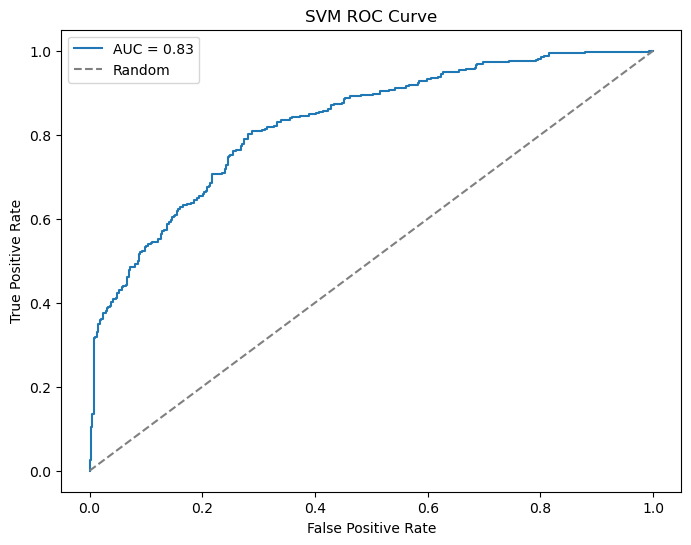

In [32]:
# ROC Curve for SVM
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test_binary, svm_model.decision_function(X_test_vec))
roc_auc_svm = roc_auc_score(y_test_binary, svm_model.decision_function(X_test_vec))

plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f'AUC = {roc_auc_svm:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('SVM ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Naive Bayes Model Implementation:

In [33]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import GridSearchCV

In [34]:
# Assuming 'text' is your feature and 'meaning' is the target variable
X_train, X_test, y_train, y_test = train_test_split(
    posts['text'],
    posts['meaning'],
    test_size=0.2,
    random_state=42
)

In [35]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [36]:
# Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)

MultinomialNB()

In [37]:
# Predictions
nb_y_pred = nb_model.predict(X_test_vec)

In [38]:
# Convert 'Stressed' and 'Unstressed' to binary labels
label_binarizer = LabelBinarizer()
y_test_binary = label_binarizer.fit_transform(y_test)
nb_y_pred_binary = label_binarizer.transform(nb_y_pred)

In [39]:
# Create a parameter grid to search
param_grid = {'alpha': [0.1, 0.5, 1.0],
              'fit_prior': [True, False]}

In [40]:
# Initialize the Naive Bayes model
nb_model = MultinomialNB()

In [41]:
# Perform GridSearchCV
grid_search = GridSearchCV(nb_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_vec, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.5, 1.0], 'fit_prior': [True, False]},
             scoring='accuracy')

In [42]:
# Get the best parameters
best_params = grid_search.best_params_

In [43]:
# Use the best parameters to train the final model
best_nb_model = MultinomialNB(alpha=best_params['alpha'], fit_prior=best_params['fit_prior'])
best_nb_model.fit(X_train_vec, y_train)

MultinomialNB(alpha=0.5, fit_prior=False)

In [44]:
# Predictions with the best model
best_nb_y_pred = best_nb_model.predict(X_test_vec)

In [45]:
# Evaluate the performance of the best model
print("Best Naive Bayes Model:")
print("Accuracy:", accuracy_score(y_test_binary, label_binarizer.transform(best_nb_y_pred)))
print("Classification Report:\n", classification_report(y_test_binary, label_binarizer.transform(best_nb_y_pred)))

Best Naive Bayes Model:
Accuracy: 0.7468354430379747
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.84      0.78       388
           1       0.77      0.63      0.69       323

    accuracy                           0.75       711
   macro avg       0.75      0.74      0.74       711
weighted avg       0.75      0.75      0.74       711



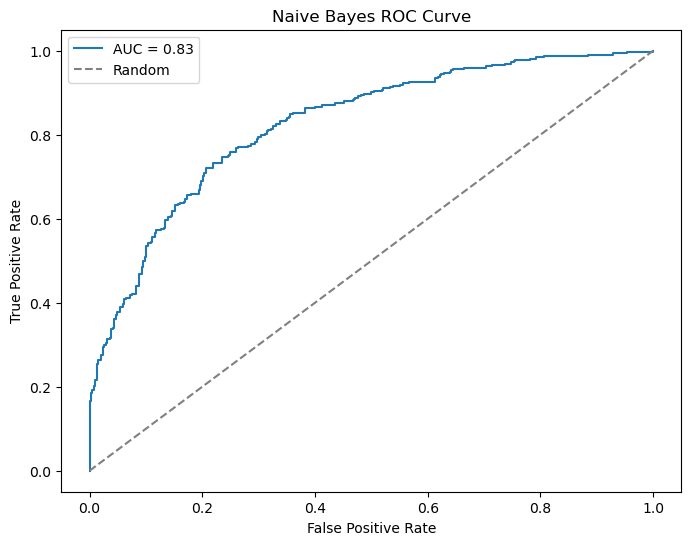

In [46]:
# Get predicted probabilities for the positive class
nb_y_probs = best_nb_model.predict_proba(X_test_vec)[:, 1]

# Compute ROC curve and AUC
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test_binary, nb_y_probs)
roc_auc_nb = roc_auc_score(y_test_binary, nb_y_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_nb, tpr_nb, label=f'AUC = {roc_auc_nb:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('Naive Bayes ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()